# eDisGo basic emobility example

This example shows you the first steps how to integrate electromobility into eDisGo.

### Learn more about eDisGo

* __[eDisGo Source Code](https://github.com/openego/eDisGo)__
* __[eDisGo Documentation](http://edisgo.readthedocs.io/en/dev/)__

### Table of Contents


* [Installation](#installation)
* [Settings](#settings)
* [eDisGo add electromobility](#emob)
* [eDisGo electromobility data structure](#network)

## Installation <a class="anchor" id="installation"></a>

This notebook requires a working installation of eDisGo as well as `jupyter notebook` to run the example and `contextily` to view the grid topology on a map. You can install all of these as follows:

```python
pip install eDisGo[examples,geoplot]
```

Checkout the eDisGo documentation on [how to install eDisGo](https://edisgo.readthedocs.io/en/dev/quickstart.html#getting-started) for more information.

#### Import packages

In [1]:
import requests
import pandas as pd

from pathlib import Path

from edisgo.edisgo import import_edisgo_from_files
from edisgo.tools.tools import select_worstcase_snapshots
from copy import deepcopy

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/sqlalchemy/ext/declarative/base.py:433: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



### Settings <a class="anchor" id="settings"></a>

The class **EDisGo** serves as the top-level API for
setting up your scenario, invocation of data import, power flow analysis, grid reinforcement and flexibility measures. It also provides access to all relevant data. See the [class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) for more information.

#### Distribution grid data

Currently, synthetic grid data generated with the python project
[ding0](https://github.com/openego/ding0)
is the only supported data source for distribution grid data. ding0 provides the grid topology data in the form of csv files, with separate files for buses, lines, loads, generators, etc. You can retrieve ding0 data from
[Zenodo](https://zenodo.org/record/890479)
(make sure you choose latest data) or check out the
[Ding0 documentation](https://dingo.readthedocs.io/en/dev/usage_details.html#ding0-examples)
on how to generate grids yourself. A ding0 example grid can be viewed [here](https://github.com/openego/eDisGo/tree/dev/tests/data/ding0_test_network_2). It is possible to provide your own grid data if it is in the same format as the ding0 grid data. 

This example works with any ding0 grid data. If you don't have grid data yet, you can execute the following to download the example grid data mentioned above.

In [2]:
def download_ding0_example_grid_3():
    ding0_example_grid_path = Path().home() / ".edisgo" / "ding0_test_network_3"

    sub_dirs = ["timeseries", "topology"]

    file_names = {
        "timeseries": [
            "generators_active_power",
            "generators_reactive_power",
            "loads_active_power",
            "loads_reactive_power",
        ],
        "topology": [
            "buses",
            "generators",
            "lines",
            "loads",
            "network",
            "switches",
            "transformers",
            "transformers_hvmv",
        ],
    }

    for sub_dir in sub_dirs:
        data_path = ding0_example_grid_path / sub_dir

        data_path.mkdir(parents=True, exist_ok=True)

        for f in file_names[sub_dir]:
            req = requests.get(
                "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                f"ding0_test_network_3/{sub_dir}/{f}.csv"
            )

            file_path = data_path / f"{f}.csv"

            with open(file_path, "wb") as fout:
                fout.write(req.content)

    return ding0_example_grid_path


ding0_example_grid_path = download_ding0_example_grid_3()

Now we are ready to initialize the edisgo object and conducts a static, non-linear power flow analysis for the worst case time steps.

In [13]:
edisgo = import_edisgo_from_files(ding0_example_grid_path, import_timeseries=True)

In [4]:
worst_case_timesteps = select_worstcase_snapshots(edisgo)
worst_case_timesteps = pd.DatetimeIndex(
    [
        worst_case_timesteps["min_residual_load"],
        worst_case_timesteps["max_residual_load"],
    ]
)
edisgo.analyze(timesteps=worst_case_timesteps)

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.112010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.146186 seconds


DatetimeIndex([], dtype='datetime64[ns]', name='snapshot', freq=None)

In [5]:
edisgo.reinforce(timesteps_pfa=worst_case_timesteps)

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.109617 seconds
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.149255 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.110075 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.117735 seconds
INFO:edisgo.flex_opt.reinforce_grid:==> Load issues were solved in 1 iteration step(s).
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:0

### eDisGo add electromobility <a class="anchor" id="emob"></a>

#### Electromobility data
So far, adding electormobility data to an eDisGo object requires electromobility data from SimBEV (required version: 3083c5a) and TracBEV (required version: 14d864c) to be stored in the directories specified through the parameters simbev_directory and tracbev_directory. SimBEV provides data on standing times, charging demand, etc. per vehicle, whereas TracBEV provides potential charging point locations.

If you don't have simBEV and tracBEV data yet, you can execute the following to download the example data for the ding0 grid downloaded above.

In [6]:
def download_simBEV_tracBEV_data():
    simBEV_tracBEV_path = Path().home() / ".edisgo"

    sub_dirs = [
        "simbev_example_scenario/simbev_run/09184119",
        "tracbev_example_scenario",
    ]

    file_names = {
        "simbev_example_scenario/simbev_run/09184119": [
            "bev_luxury_00000_90kWh_LR_Zentr_events",
            "bev_medium_00000_65kWh_LR_Zentr_events",
            "bev_medium_00001_65kWh_LR_Zentr_events",
            "bev_medium_00002_65kWh_LR_Zentr_events",
            "bev_mini_00000_30kWh_LR_Zentr_events",
            "bev_mini_00001_30kWh_LR_Zentr_events",
            "phev_luxury_00000_20kWh_LR_Zentr_events",
            "phev_medium_00000_20kWh_LR_Zentr_events",
            "phev_medium_00001_20kWh_LR_Zentr_events",
            "phev_mini_00000_20kWh_LR_Zentr_events",
        ],
        "tracbev_example_scenario": [
            "output_home_09184119",
            "output_hpc_09184119",
            "output_public_09184119",
            "output_work_09184119",
        ],
    }

    for sub_dir in sub_dirs:
        data_path = simBEV_tracBEV_path / sub_dir

        data_path.mkdir(parents=True, exist_ok=True)

        for f in file_names[sub_dir]:
            req = requests.get(
                "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                f"{sub_dir}/{f}.csv"
            )

            file_path = data_path / f"{f}.csv"

            with open(file_path, "wb") as fout:
                fout.write(req.content)

            if sub_dir == "tracbev_example_scenario":
                req = requests.get(
                    "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
                    f"{sub_dir}/{f}.gpkg"
                )

                file_path = data_path / f"{f}.gpkg"

                with open(file_path, "wb") as fout:
                    fout.write(req.content)

    data_path = simBEV_tracBEV_path / "simbev_example_scenario"
    req = requests.get(
        "https://raw.githubusercontent.com/openego/eDisGo/dev/tests/data/"
        "simbev_example_scenario/metadata_simbev_run.json"
    )

    file_path = data_path / "metadata_simbev_run.json"

    with open(file_path, "wb") as fout:
        fout.write(req.content)


download_simBEV_tracBEV_data()

In order to import the electromobility data of the grid that you downloaded above and integrate charging points into grid, you can use the function `import_electromobility`. 
After electromobility data is loaded, the charging demand from SimBEV is allocated to potential charging points from TracBEV. Afterwards, all potential charging points with charging demand allocated to them are integrated into the grid. This is realised the following way:
* If power rating < 0.3 MVA, then the charging demand is integrated in LV grid; otherwise integration in MV grid
* Integration in LV grid:
    * Integration in LV grid which distribution station is closest to the considered charging point
    * For power ratings > 0.1 MVA the charging point is connected directly to the distribution station
    * For power ratings < 0.1 MVA the type of connection depends on the use case:
        - Use Case `home`: Charging point is connected to a random household load on the identified LV grid
        - Use Case `work`: Charging point is connected to a random commercial, industrial or agricultural consumer
        - Use Case `public`: Charging point is connected to a random consumer that does not represent a household load
* Integration in MV grid:: 
    * The charging station is connected to the nearest network node or cable
    * If a cable is selected, the line is cut at the point closest to the charging station and a new cable closure is added to which the charging station is connected
    * If the connection power of the charging point is > 4.5 MVA, the charging station is connected directly to the HV-MV substation

In [15]:
edisgo.import_electromobility(
    simbev_directory=Path("/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/tests/data/simbev_example_scenario"),
    tracbev_directory=Path().home() / ".edisgo/tracbev_example_scenario",
    # simbev_directory=Path().home() / ".edisgo/simbev_example_scenario",
    # tracbev_directory=Path().home() / ".edisgo/tracbev_example_scenario",
)
edisgo2 = deepcopy(edisgo)
edisgo3 = deepcopy(edisgo)

INFO:fiona.ogrext:Failed to auto identify EPSG: 7
/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: S

In [16]:
edisgo.electromobility.charging_processes_df

,ags,car_id,destination,use_case,nominal_charging_capacity_kW,grid_charging_capacity_kW,chargingdemand_kWh,park_time_timesteps,park_start_timesteps,park_end_timesteps,charging_park_id,charging_point_id
0,9184119,0,4_private/ridesharing,public,11.0,12.2222,68.7500,25,0,44,257,52
1,9184119,1,5_leisure,public,22.0,24.4444,23.4683,84,75,158,368,66
2,9184119,1,4_private/ridesharing,public,50.0,55.5556,35.6030,75,514,588,381,71
3,9184119,2,6_home,public,11.0,12.2222,5.4300,67,167,233,204,64
4,9184119,2,0_work,public,50.0,55.5556,7.6262,18,319,336,381,71
...,...,...,...,...,...,...,...,...,...,...,...,...
368,9184119,98,5_leisure,public,11.0,12.2222,12.4162,9,244,252,266,61
369,9184119,98,4_private/ridesharing,public,11.0,12.2222,9.3277,53,511,563,266,61
370,9184119,99,3_shopping,public,11.0,12.2222,13.7500,5,34,38,391,55
371,9184119,99,4_private/ridesharing,public,11.0,12.2222,8.2500,3,349,351,204,64


### eDisGo electromobility data structure <a class="anchor" id="network"></a>

The EDisGo class serves as the top-level API and provides access to all relevant data.

Grid data is stored in the [Topology](https://edisgo.readthedocs.io/en/dev/api/edisgo.network.html#edisgo.network.topology.Topology) class.
Time series data can be found in the [TimeSeries](https://edisgo.readthedocs.io/en/dev/api/edisgo.network.html#edisgo.network.timeseries.TimeSeries) class. Results data holding results e.g. from the power flow analysis and grid expansion is stored in the [Results](https://edisgo.readthedocs.io/en/dev/api/edisgo.network.html#edisgo.network.results.Results) class.
Configuration data from the config files (see [default_configs](https://edisgo.readthedocs.io/en/dev/configs.html#default-configuration-data)) is stored
in the [Config](https://edisgo.readthedocs.io/en/dev/api/edisgo.tools.html#edisgo.tools.config.Config) class.
All these can be accessed as follows:

```python
edisgo.topology
edisgo.timeseries
edisgo.results
edisgo.config
```

The electromobility data in the Topology object is stored in a pandas DataFrame and can be accessed as follows:

In [8]:
edisgo.topology.charging_points_df.head()

,bus,p_set,annual_consumption,sector,type,p,mvlv_subst_id,geom,voltage_level
Charging_Point_LVGrid_20543_home_1,BranchTee_mvgd_2534_lvgd_20543_202,0.0122,NaN,home,charging_point,0.0122,20543.0,POINT (11.60644729360077 48.248289543410564),7.0
Charging_Point_LVGrid_20564_home_1,BranchTee_mvgd_2534_lvgd_20564_106,0.0122,NaN,home,charging_point,0.0122,20564.0,POINT (11.645411334679864 48.245916092717714),7.0
Charging_Point_LVGrid_20572_home_1,BranchTee_mvgd_2534_lvgd_20572_106,0.0122,NaN,home,charging_point,0.0122,20572.0,POINT (11.654771276522016 48.243976403882435),7.0
Charging_Point_LVGrid_20579_home_1,BranchTee_mvgd_2534_lvgd_20579_106,0.0122,NaN,home,charging_point,0.0122,20579.0,POINT (11.657698017825746 48.25113187539169),7.0
Charging_Point_LVGrid_20565_home_1,BranchTee_mvgd_2534_lvgd_20565_106,0.0122,NaN,home,charging_point,0.0122,20565.0,POINT (11.642807867380885 48.24865460210316),7.0


Be aware that the import_electromobility() function does not yield charging time series per charging point but only charging processes. The actual charging time series are determined through applying a charging strategy using the function charging_strategy.

The charging processes can be accessed through the edisgo.network.electromobility module as follows:

In [9]:
edisgo.electromobility.charging_processes_df.head()

,ags,car_id,destination,use_case,nominal_charging_capacity_kW,grid_charging_capacity_kW,chargingdemand_kWh,park_time_timesteps,park_start_timesteps,park_end_timesteps,charging_park_id,charging_point_id
0,9184119,0,4_private/ridesharing,public,50.0,55.5556,25.0000,2,63,64,257,11
1,9184119,0,0_work,work,22.0,24.4444,16.4184,22,223,244,426,0
2,9184119,0,0_work,work,22.0,24.4444,8.4318,39,511,549,426,0
3,9184119,0,7_charging_hub,hpc,150.0,166.6667,37.5000,1,562,563,164,10
4,9184119,0,7_charging_hub,hpc,150.0,166.6667,37.5000,1,570,571,164,10


In order to obtain charging time series, a charging strategy to set EV charging time series at charging parks has to be applied. The aim of the charging strategies is to generate the most grid-friendly charging behavior possible without restricting the convenience for end users. Therefore, the boundary condition of all charging strategies is that the charging requirement of each charging process must be fully covered. This means that charging processes can only be used as a flexibility if the e-car can be fully charged while it is stationary. Furthermore, only private charging processes can be used as a flexibility, since the fulfillment of the service is the priority for public charging processes. In order to be able to evaluate the three charging strategies, a reference charging strategy is also examined.
The eDisGo tool offers three different charging strategies: `dumb`, `reduced` and `residual`.

* `dumb`: is the default charging strategy and corresponds to the reference charging. The cars are charged directly after arrival with the maximum possible charging capacity. 

* `reduced`: preventive charging strategy. The cars are charged directly after arrival with the minimum possible charging power. The minimum possible charging power is determined by the parking time and the parameter minimum_charging_capacity_factor.

* `residual`: active charging strategy. The cars are charged when the residual load in the MV grid is lowest (high generation and low consumption). Charging processes with a low flexibility are given priority.

INFO:root:Charging strategy dumb completed.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.106268 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.111332 seconds
/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



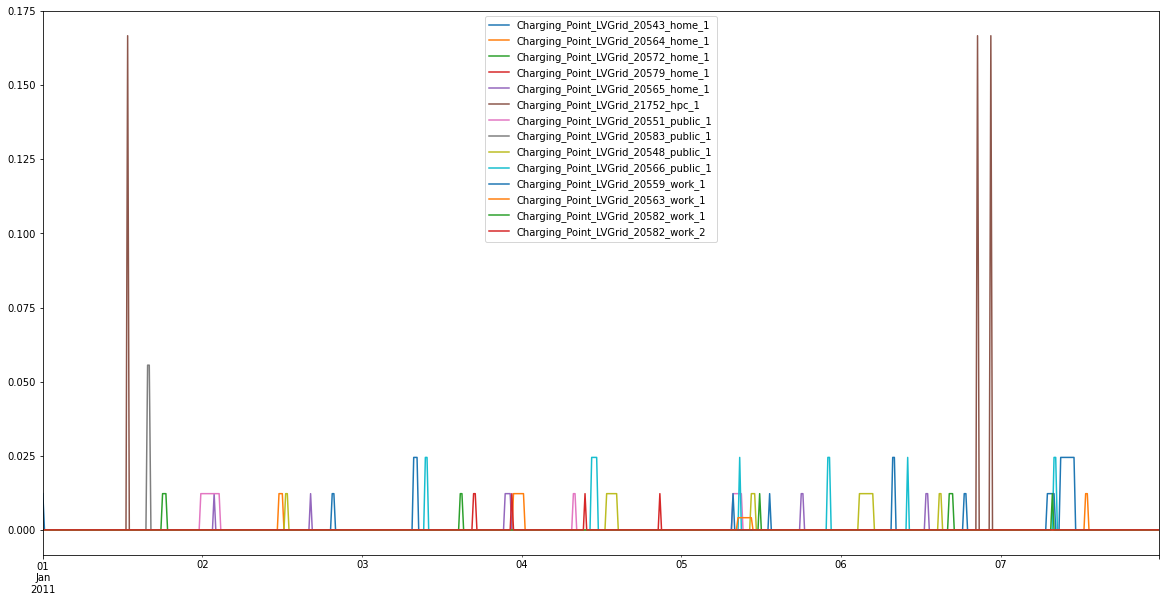

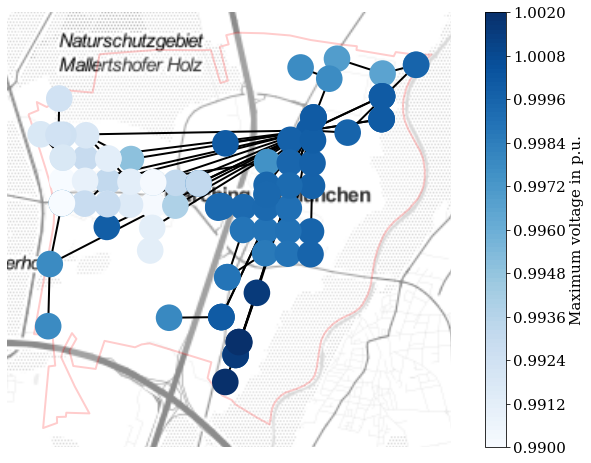

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



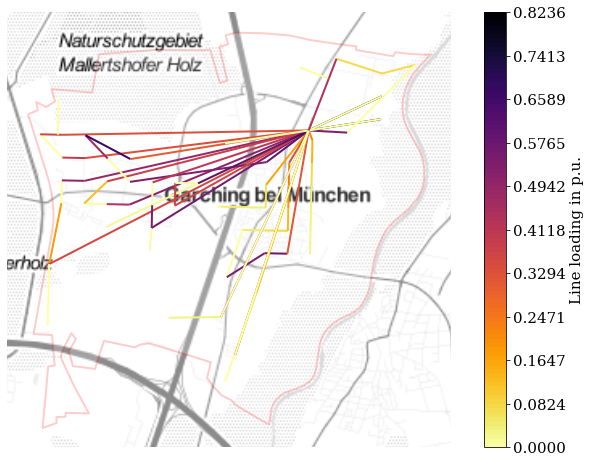

In [10]:
edisgo.apply_charging_strategy()
edisgo.timeseries.charging_points_active_power(edisgo).plot(figsize=(20, 10))
edisgo.analyze(timesteps=worst_case_timesteps)
edisgo.plot_mv_voltages()
edisgo.plot_mv_line_loading()

To change the charging strategy from the default `dumb` to one of the other strategies, the `strategy` parameter has to be set accordingly:

INFO:root:Charging strategy reduced completed.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.114558 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.105191 seconds
/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



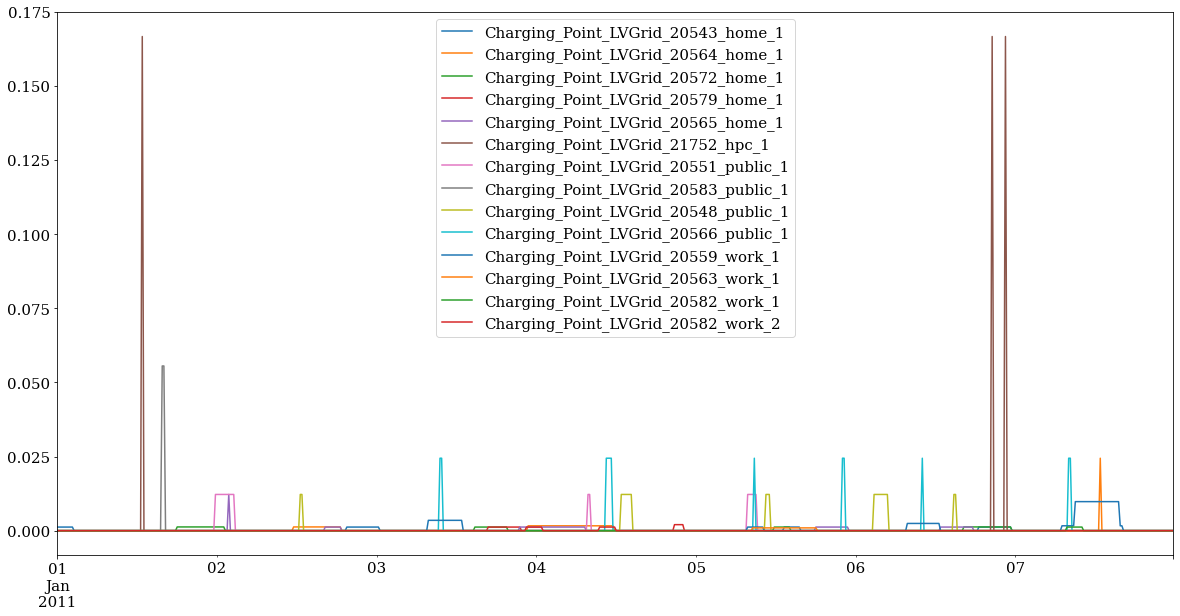

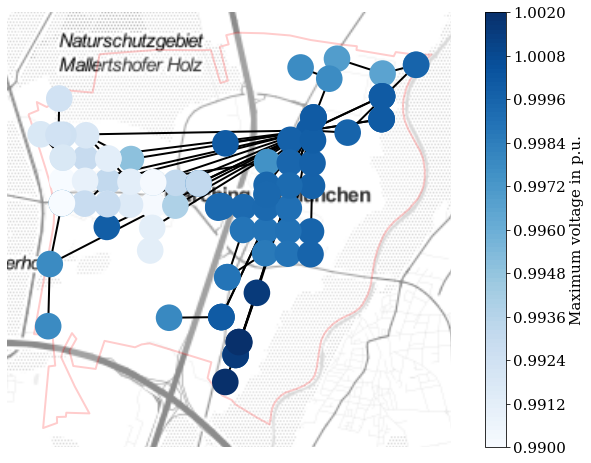

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



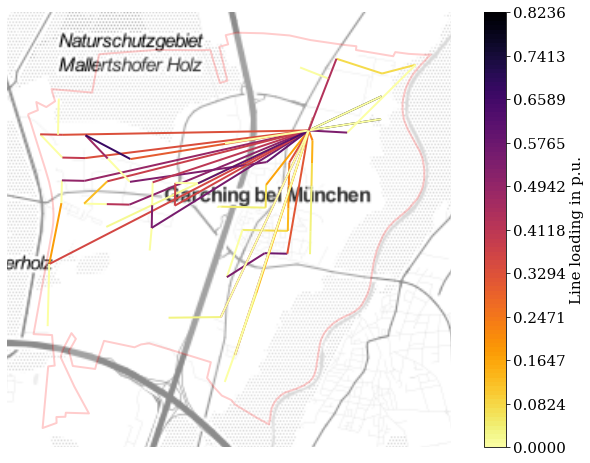

In [11]:
edisgo2.apply_charging_strategy(strategy="reduced")
edisgo2.timeseries.charging_points_active_power(edisgo).plot(figsize=(20, 10))
edisgo2.analyze(timesteps=worst_case_timesteps)
edisgo2.plot_mv_voltages()
edisgo2.plot_mv_line_loading()

INFO:root:Charging strategy residual completed.
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 04:00:00', '2011-01-07 11:00:00'], dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.103412 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.106151 seconds
/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



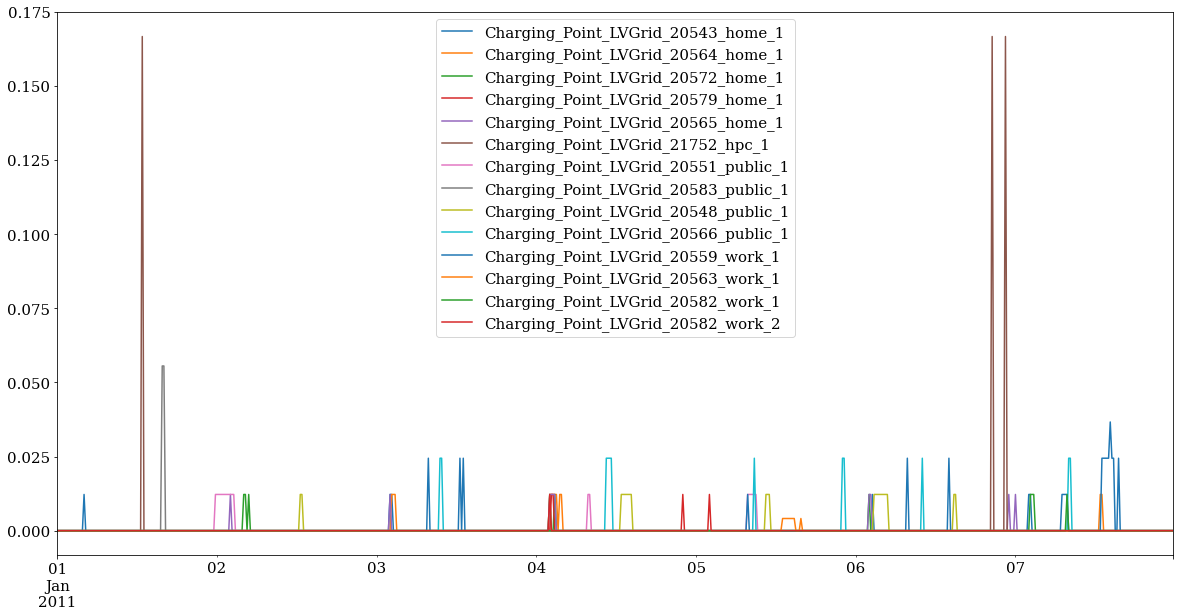

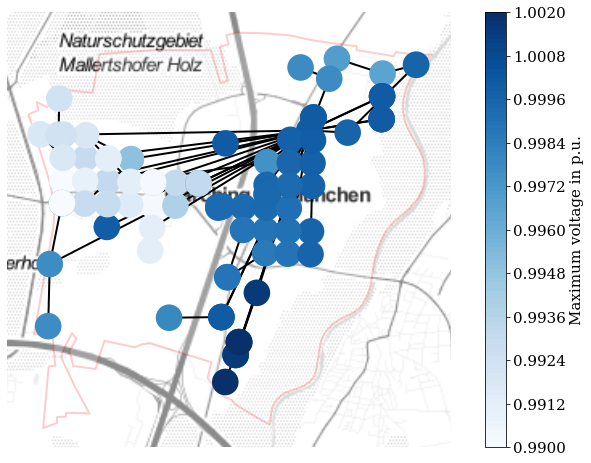

/home/kilian/Documents/PythonProjects/eDisGo_orig/eDisGo/edisgo/tools/plots.py:574: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/kilian/Documents/PythonProjects/eDisGo_orig/d_py38_edisgo/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



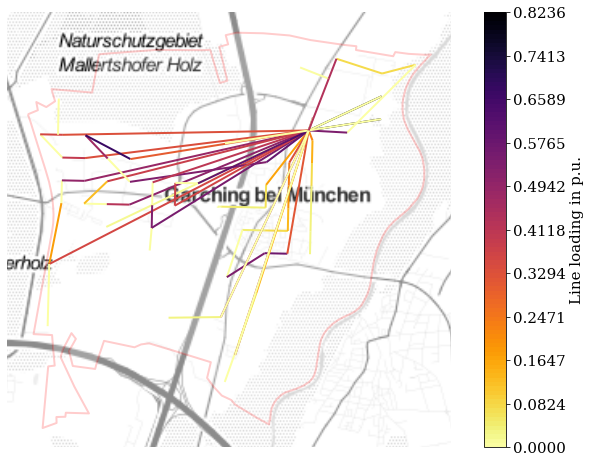

In [12]:
edisgo3.apply_charging_strategy(strategy="residual")
edisgo3.timeseries.charging_points_active_power(edisgo).plot(figsize=(20, 10))
edisgo3.analyze(timesteps=worst_case_timesteps)
edisgo3.plot_mv_voltages()
edisgo3.plot_mv_line_loading()